In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import imageio
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from PIL import Image
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)
# data structure as follows
# 
# data
      #  ./data/origin
    #  ./data/label
    #  ./data/background_masks
    # ./data/firstresult
    # ./data/lastresult(after postprocessing)
#This code refers to the following link
#https://github.com/getsanjeev/retina-features

In [2]:
def alternateSequentialFiltering(image):
    # ASF(alternate sequential filtering) Smooth the whole picture
    open1 = cv2.morphologyEx(image, cv2.MORPH_OPEN,
                          cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    close1 = cv2.morphologyEx(open1, cv2.MORPH_CLOSE, cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (7, 7)), iterations=1)
    open2 = cv2.morphologyEx(close1, cv2.MORPH_OPEN, cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    close2 = cv2.morphologyEx(open2, cv2.MORPH_CLOSE, cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (13, 13)), iterations=1)
    open3 = cv2.morphologyEx(close2, cv2.MORPH_OPEN, cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    close3 = cv2.morphologyEx(open3, cv2.MORPH_CLOSE, cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (21, 21)), iterations=1)
    return close3

def preProcess(i):
    image = cv2.imread('./data/origin/'+str(i)+'_training.tif')
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    g = image[:, :, 1]
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    plt.subplot(1,3,1)
    plt.imshow(g), plt.title(f"Green channel {i}", {"fontsize": 24})
    plt.subplot(1,3,2), plt.title(f"CLAHE {i}", {"fontsize": 24})
    plt.imshow(contrast_g_fundus, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"SMOOTH{i} ", {"fontsize": 24})
    plt.imshow(R3, cmap="gray")
    plt.show()

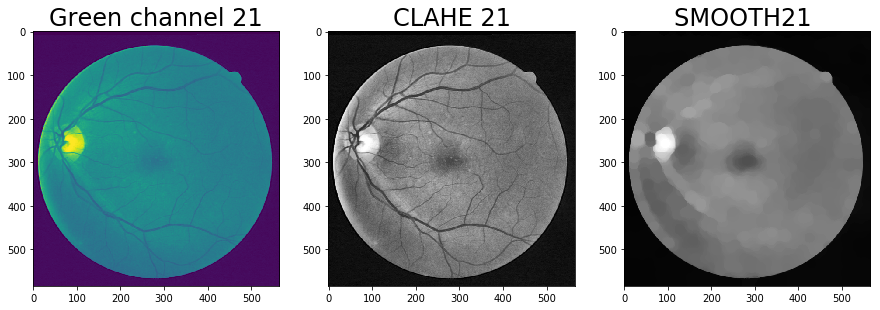

In [5]:
preProcess(21)

In [8]:
def hiscompare(i):
    image = cv2.imread('./data/origin/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    im = Image.open('./data/label/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    plt.subplot(3,2,1)
    plt.hist(contrast_g_fundus.ravel(),256,[1,256]), plt.title(f"CLAHE {i}", {"fontsize": 24})
    plt.subplot(3,2,2)
    plt.imshow(contrast_g_fundus, cmap="gray")
    plt.subplot(3,2,3), plt.title(f"SMOOTH {i}", {"fontsize": 24})
    plt.hist(R3.ravel(),256,[1,256])
    plt.subplot(3,2,4)
    plt.imshow(R3, cmap="gray")
    plt.subplot(3,2,5), plt.title(f"subtract {i} ", {"fontsize": 24})
    plt.hist(f5.ravel(),256,[1,256])
    plt.subplot(3,2,6)
    plt.imshow(f5, cmap="gray")
    plt.show()

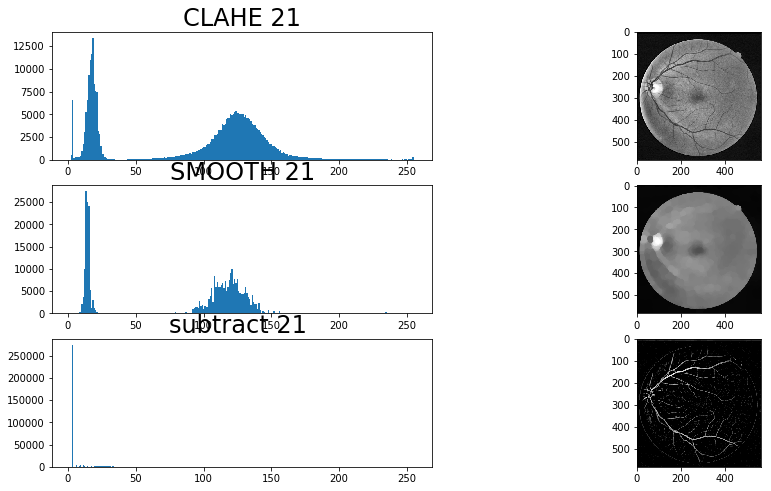

In [9]:
hiscompare(21)

In [10]:
def postProcess(i):
    image = cv2.imread('./data/origin/'+str(i)+'_training.tif')
    g = image[:, :, 1]
    im = Image.open('./data/label/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_g_fundus = clahe.apply(g)
    R3 = alternateSequentialFiltering(contrast_g_fundus)
    f4 = cv2.subtract(R3, contrast_g_fundus)
    f5 = clahe.apply(f4)
    _, thresh = cv2.threshold(f5, 15, 255, cv2.THRESH_BINARY)
    maskSmallContour = np.ones(f5.shape[:2], dtype="uint8") * 255
    _, contoursSmall, _ = cv2.findContours(
        thresh.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for cnts in contoursSmall:
        if cv2.contourArea(cnts) <= 200:
            cv2.drawContours(maskSmallContour, [cnts], -1, 0, -1)
    im = cv2.bitwise_and(f5, f5, mask=maskSmallContour)
    _, fin = cv2.threshold(im, 30, 255, cv2.THRESH_BINARY_INV)
#     kernel = np.ones((5, 5), np.uint8)
#     result = cv2.erode(fin, kernel, iterations=1)
    result = cv2.erode(fin, cv2.getStructuringElement(
         cv2.MORPH_ELLIPSE, (3, 3)), iterations=1)
    
    fundus_eroded = cv2.bitwise_not(result)
    bigChunkmask = np.ones(f5.shape[:2], dtype="uint8") * 255
    _, xcontours, _ = cv2.findContours(
        fundus_eroded.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    for cnts in xcontours:
        peri = cv2.arcLength(cnts, True)
        shape = "unidentified"
        approxLength = cv2.approxPolyDP(cnts, 0.04 * peri, False)
        if len(approxLength) > 4 and cv2.contourArea(cnts) <= 3000 and cv2.contourArea(cnts) >= 100:
            shape = "circle"
        else:
            shape = "veins"
        if(shape == "circle"):
            cv2.drawContours(bigChunkmask, [cnts], -1, 0, -1)

    finimage = cv2.bitwise_and(fundus_eroded, fundus_eroded, mask=bigChunkmask)
    blood_vessels = cv2.bitwise_not(finimage)
    blood_vessels = cv2.bitwise_not(blood_vessels)
    cv2.imwrite('./data/firstresult/'+str(i)+'_bloodvessel.png', blood_vessels)
    
    plt.subplot(1,3,1)
    plt.imshow(f5, cmap="gray"), plt.title(f"image {i}", {"fontsize": 24})
    plt.subplot(1,3,2), plt.title(f"remove small contour {i}", {"fontsize": 24})
    plt.imshow(im, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"threshold and erode{i}", {"fontsize": 24})
    plt.imshow(blood_vessels, cmap="gray")

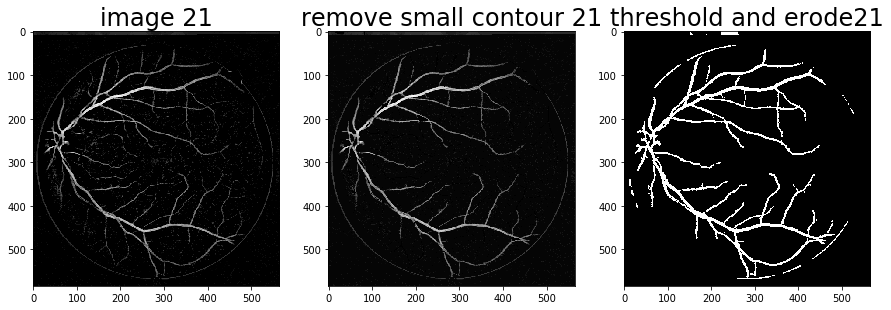

In [11]:
postProcess(21)

In [12]:
from PIL import Image
def removeBoarder(i):
    im = Image.open('./data/background_masks/'+str(i)+'_training_mask.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    image = cv2.imread('./data/firstresult/'+str(i)+'_bloodvessel.png')
    kernel = np.ones((5, 5), np.uint8)
    erosion = cv2.erode(I, kernel, iterations=3)
    result = cv2.bitwise_and(erosion, image)
    cv2.imwrite('./data/lastresult/'+str(i)+'_bloodvessel.png', result)
    plt.subplot(1,2,1)
    plt.imshow(image, cmap="gray")
    plt.subplot(1,2,2)
    plt.imshow(result, cmap="gray")

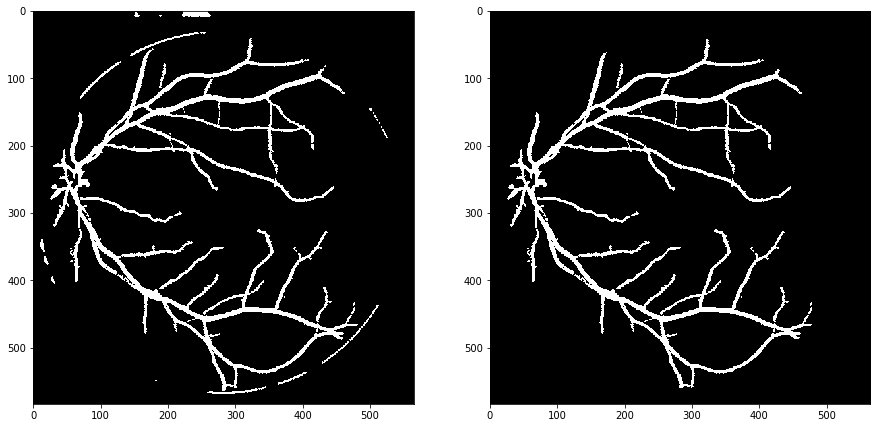

In [13]:
removeBoarder(21)

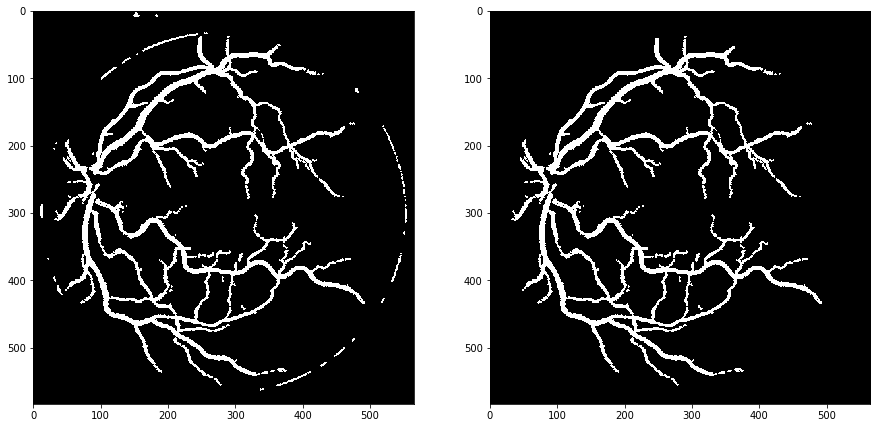

In [20]:
#generate 20 predict images
for i in range(21,40):
    postProcess(i)
    removeBoarder(i)

In [18]:
def showPicture(i):
    predict = cv2.imread('./data/lastresult/'+str(i)+'_bloodvessel.png')
    origin = cv2.imread('./data/origin/'+str(i)+'_training.tif')
    origin = cv2.cvtColor(origin, cv2.COLOR_BGR2RGB)
    im = Image.open('./data/label/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    label = np.asarray(im)
    plt.subplot(1,3,1)
    plt.imshow(origin), plt.title(f"image {i}", {"fontsize": 24})
    plt.subplot(1,3,2), plt.title(f"label {i}", {"fontsize": 24})
    plt.imshow(label, cmap="gray")
    plt.subplot(1,3,3), plt.title(f"predict{i} ", {"fontsize": 24})
    plt.imshow(predict, cmap="gray")
    plt.show()

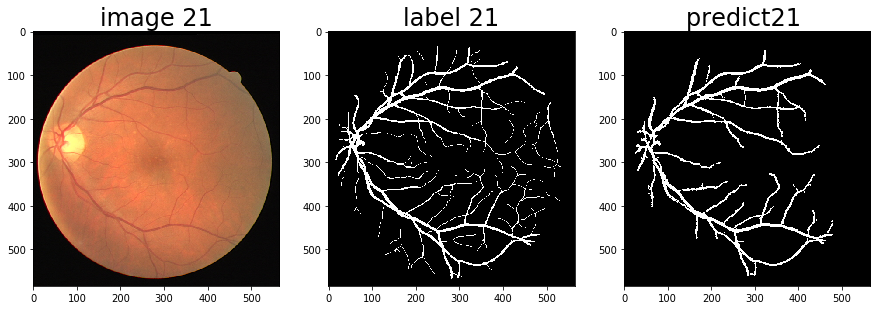

In [19]:
showPicture(21)

In [21]:
tn, fp, fn, tp = 0, 0, 0, 0

In [24]:
def accuracy(i):
    global tn, fp, fn, tp
    predict = cv2.imread('./data/lastresult/'+str(i)+'_bloodvessel.png')
    im = Image.open('./data/label/'+str(i)+'_manual1.gif')
    im = im.convert('RGB')
    I = np.asarray(im)
    for i in range(predict.shape[0]):                 
        for j in range(predict.shape[1]):
            if(predict[i,j].all()==I[i,j].all()):
                if(predict[i,j].all()==1):
                    tp+=1
                else:
                    tn+=1
            else:
                if(predict[i,j].all()==1):
                    fp+=1
                else:
                    fn+=1
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    print('current accuracy '+str(accuracy))

In [25]:
accuracy(21)

current accuracy 0.9580888592556673


In [27]:
for i in range(21,40):
    accuracy(i)

current accuracy 0.9515898621320491
current accuracy 0.9517079804139632
current accuracy 0.9513980229926859
current accuracy 0.9512333616195903
current accuracy 0.950634808881263
current accuracy 0.9510135908729678
current accuracy 0.951185641549625
current accuracy 0.9511815434263714
current accuracy 0.9514017860750799
current accuracy 0.9515059498903092
current accuracy 0.9517842124803007
current accuracy 0.951939445368952
current accuracy 0.9521322548900758
current accuracy 0.9510197772890221
current accuracy 0.9511006384612276
current accuracy 0.9507787184687415
current accuracy 0.9508425263668323
current accuracy 0.9507812135736733
current accuracy 0.9506964480543096


In [28]:
total = tp + fp + fn + tn
accuracy = (tp + tn) / total
recall = tp / (tp + fn)
precision = tp / (tp + fp)
F1 = 2*(precision*recall)/(precision+recall)
print("accuracy: "+ str(accuracy))
print("recall: "+ str(recall))
print("precision: "+ str(precision))
print("F1: "+ str(F1))

accuracy: 0.9506964480543096
recall: 0.6589407172669656
precision: 0.7408611069964943
F1: 0.6975038048637177
